#RQ1: How does product price influence customer ratings?
To explore this questions, we are going to start by using the preprocessed data (done by Christian Levec for RQ3) and discover some descriptive statistics.

##Cells run at begining everytime the notebook is loaded

In [2]:
!pip install datasets
!pip install vaderSentiment
!pip install transformers
!pip install torch
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [22]:
# Import libraries
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gzip
import json
import pandas as pd
from tqdm import tqdm
from google.colab import drive
import re
from transformers import pipeline
import torch
import ast

In [4]:
# Mount drive to access and save files to local folders
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/351_Data'
os.listdir(folder_path)

# Use cuda if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cpu


In [5]:
# Load preprocessed data and merge
df_grocery_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Grocery_and_Gourmet_Food_processed.csv')
df_grocery_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Grocery_and_Gourmet_Food_processed.csv')
df_grocery_merged = pd.merge(df_grocery_reviews, df_grocery_meta, on='parent_asin', how='left')

df_home_kitchen_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Home_and_Kitchen_processed.csv')
df_home_kitchen_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Home_and_Kitchen_processed.csv')
df_home_kitchen_merged = pd.merge(df_home_kitchen_reviews, df_home_kitchen_meta, on='parent_asin', how='left')

df_beauty_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_All_Beauty_processed.csv')
df_beauty_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/All_Beauty_processed.csv')
df_beauty_merged = pd.merge(df_beauty_reviews, df_beauty_meta, on='parent_asin', how='left')

df_elec_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Electronics_processed.csv')
df_elec_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Electronics_processed.csv')
df_elec_merged = pd.merge(df_elec_reviews, df_elec_meta, on='parent_asin', how='left')

df_pet_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Pet_Supplies_processed.csv')
df_pet_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Pet_Supplies_processed.csv')
df_pet_merged = pd.merge(df_pet_reviews, df_pet_meta, on='parent_asin', how='left')


<ipython-input-5-358ef63cfab1>:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_elec_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Electronics_processed.csv')


In [6]:
# Dictionaries used throughout the notebook
meta_dfs = {
    'Grocery': df_grocery_meta,
    'Home & Kitchen': df_home_kitchen_meta,
    'Beauty': df_beauty_meta,
    'Electronics': df_elec_meta,
    'Pet Supplies': df_pet_meta
}

merged_dfs = {
    'Grocery': df_grocery_merged,
    'Home & Kitchen': df_home_kitchen_merged,
    'Beauty': df_beauty_merged,
    'Electronics': df_elec_merged,
    'Pet Supplies': df_pet_merged
}


##Look at basic stats for each metadata dataset


 Grocery Metadata Stats
Total Products: 100000
Products with Price: 43121
Average Price: $25.75
Median Price: $17.99
Average Rating: 4.20
Total Number of Ratings: 38576773


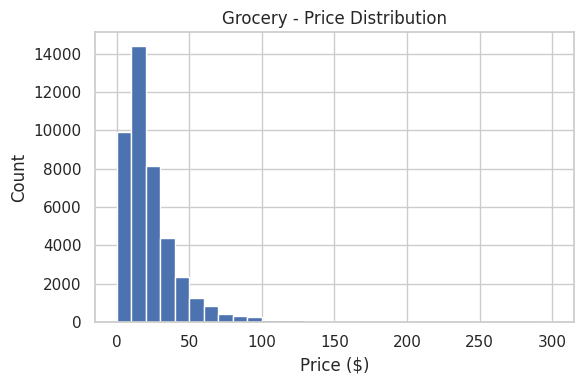


 Home & Kitchen Metadata Stats
Total Products: 100000
Products with Price: 50108
Average Price: $52.67
Median Price: $22.99
Average Rating: 4.25
Total Number of Ratings: 52463601


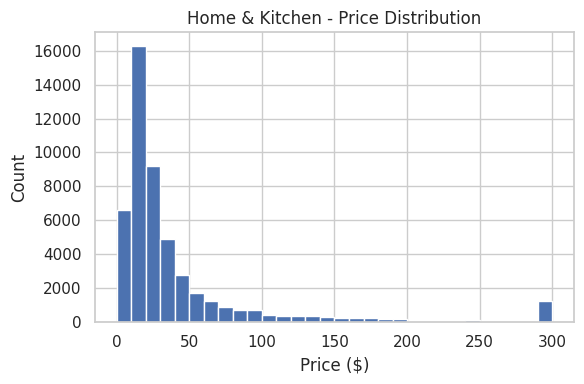


 Beauty Metadata Stats
Total Products: 100000
Products with Price: 16200
Average Price: $27.14
Median Price: $16.95
Average Rating: 3.90
Total Number of Ratings: 5400731


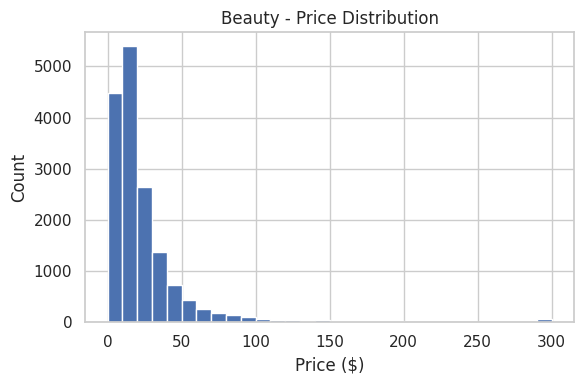


 Electronics Metadata Stats
Total Products: 100000
Products with Price: 41823
Average Price: $87.52
Median Price: $20.89
Average Rating: 4.07
Total Number of Ratings: 45056511


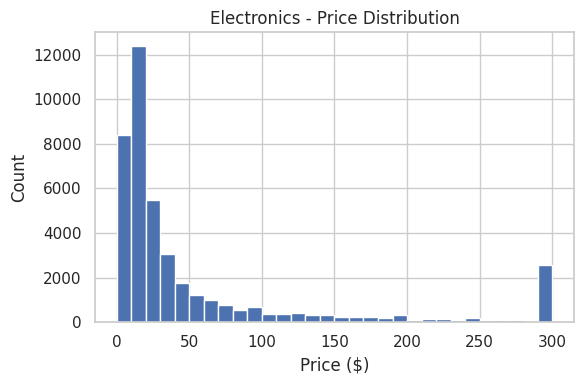


 Pet Supplies Metadata Stats
Total Products: 100000
Products with Price: 45588
Average Price: $31.44
Median Price: $17.99
Average Rating: 4.08
Total Number of Ratings: 47667973


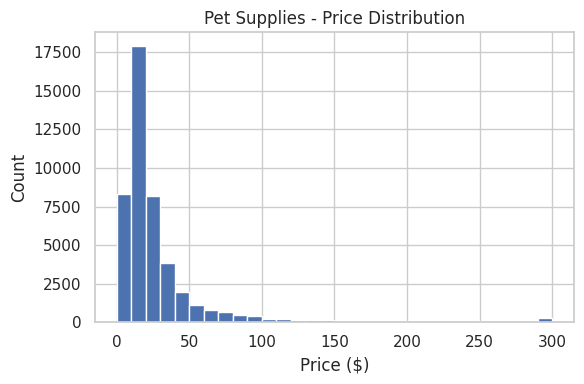

In [24]:
for name, df in meta_dfs.items():
    print(f"\n {name} Metadata Stats")

    # Make price is numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

    # Calculate descriptive statistics
    total = len(df)
    price_count = df['price'].notna().sum()
    avg_price = df['price'].mean()
    median_price = df['price'].median()
    avg_rating = df['average_rating'].dropna().astype(float).mean()
    total_ratings = df['rating_number'].dropna().astype(int).sum()

    # Print descriptive statistics
    print(f"Total Products: {total}")
    print(f"Products with Price: {price_count}")
    print(f"Average Price: ${avg_price:.2f}")
    print(f"Median Price: ${median_price:.2f}")
    print(f"Average Rating: {avg_rating:.2f}")
    print(f"Total Number of Ratings: {total_ratings}")

    # Price distribution plot
    plt.figure(figsize=(6, 4))
    df['price'].dropna().clip(0, 300).hist(bins=30)
    plt.title(f'{name} - Price Distribution')
    plt.xlabel('Price ($)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

##Look at basics stats for merged datasets




===== Grocery Review Stats =====
Total Reviews: 100000
Average Rating: 4.31
Median Rating: 5.00
Standard Deviation: 1.19
Reviews with Text: 99986
Reviews without Text: 14
Verified Purchases: 78613
Unverified Purchases: 21387


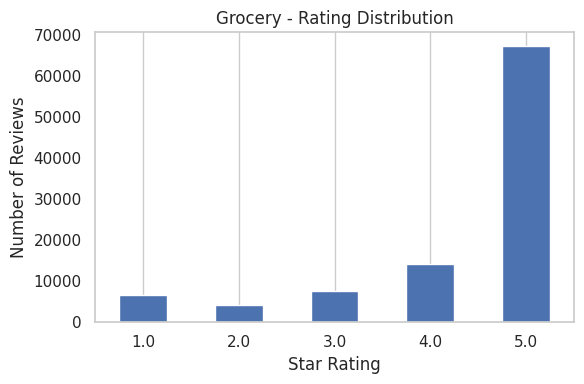


===== Home & Kitchen Review Stats =====
Total Reviews: 100000
Average Rating: 4.39
Median Rating: 5.00
Standard Deviation: 1.12
Reviews with Text: 99992
Reviews without Text: 8
Verified Purchases: 70852
Unverified Purchases: 29148


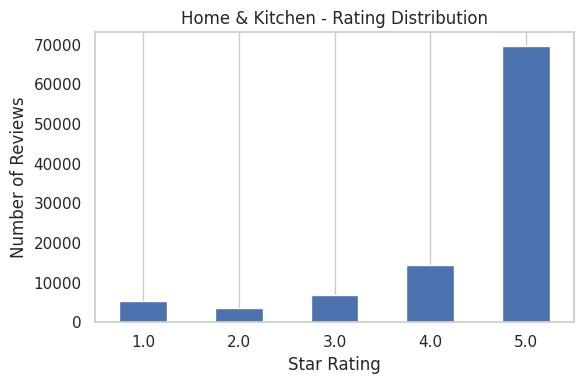


===== Beauty Review Stats =====
Total Reviews: 100000
Average Rating: 4.06
Median Rating: 5.00
Standard Deviation: 1.39
Reviews with Text: 99983
Reviews without Text: 17
Verified Purchases: 87784
Unverified Purchases: 12216


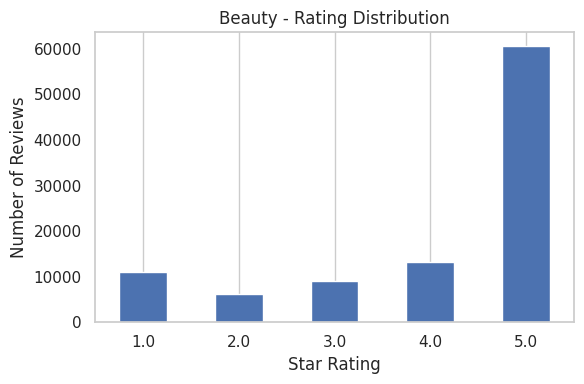


===== Electronics Review Stats =====
Total Reviews: 100000
Average Rating: 4.26
Median Rating: 5.00
Standard Deviation: 1.25
Reviews with Text: 99988
Reviews without Text: 12
Verified Purchases: 78983
Unverified Purchases: 21017


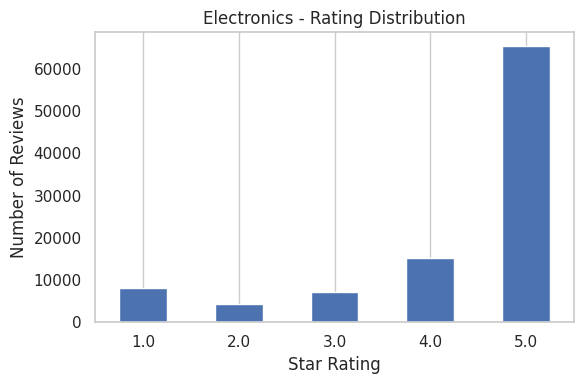


===== Pet Supplies Review Stats =====
Total Reviews: 100000
Average Rating: 4.22
Median Rating: 5.00
Standard Deviation: 1.25
Reviews with Text: 99989
Reviews without Text: 11
Verified Purchases: 80790
Unverified Purchases: 19210


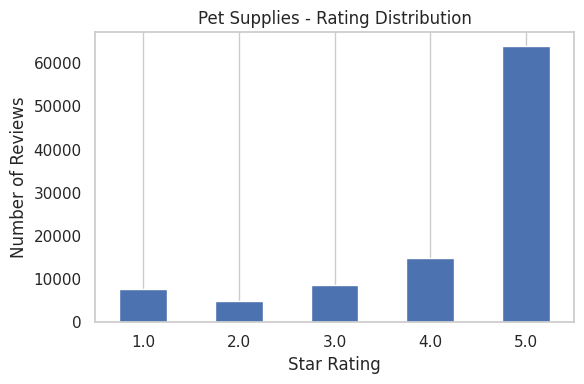

In [25]:
for name, df in merged_dfs.items():
    print(f"\n===== {name} Review Stats =====")

    # Make price is numeric
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

    # Drop rows with missing ratings
    df_reviews_only = df.dropna(subset=['rating'])

    # Calculate statistics
    total_reviews = len(df_reviews_only)
    avg_rating = df_reviews_only['rating'].mean()
    median_rating = df_reviews_only['rating'].median()
    std_rating = df_reviews_only['rating'].std()
    num_with_text = df_reviews_only['text'].notna().sum()
    num_without_text = total_reviews - num_with_text
    verified = df_reviews_only['verified_purchase'].value_counts().get(True, 0)
    unverified = df_reviews_only['verified_purchase'].value_counts().get(False, 0)

    # Print descriptive statistics
    print(f"Total Reviews: {total_reviews}")
    print(f"Average Rating: {avg_rating:.2f}")
    print(f"Median Rating: {median_rating:.2f}")
    print(f"Standard Deviation: {std_rating:.2f}")
    print(f"Reviews with Text: {num_with_text}")
    print(f"Reviews without Text: {num_without_text}")
    print(f"Verified Purchases: {verified}")
    print(f"Unverified Purchases: {unverified}")

    # Rating distribution plot
    rating_counts = df_reviews_only['rating'].value_counts().sort_index()

    plt.figure(figsize=(6, 4))
    rating_counts.plot(kind='bar')
    plt.title(f'{name} - Rating Distribution')
    plt.xlabel('Star Rating')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


##Look at ratings for various price brackets in merged datasets



Grocery - Review Stats by Price Bracket

Price Bracket: $0–10
  Total Reviews: 6551
  Average Rating: 4.33
  Median Rating: 5.00
  Std Dev of Rating: 1.20
  Reviews with Text: 6549
  Reviews without Text: 2
  Verified Purchases: 5556
  Unverified Purchases: 995

Price Bracket: $10–20
  Total Reviews: 7669
  Average Rating: 4.35
  Median Rating: 5.00
  Std Dev of Rating: 1.17
  Reviews with Text: 7669
  Reviews without Text: 0
  Verified Purchases: 6345
  Unverified Purchases: 1324

Price Bracket: $20–30
  Total Reviews: 4904
  Average Rating: 4.32
  Median Rating: 5.00
  Std Dev of Rating: 1.19
  Reviews with Text: 4904
  Reviews without Text: 0
  Verified Purchases: 3957
  Unverified Purchases: 947

Price Bracket: $30–50
  Total Reviews: 4384
  Average Rating: 4.31
  Median Rating: 5.00
  Std Dev of Rating: 1.23
  Reviews with Text: 4381
  Reviews without Text: 3
  Verified Purchases: 3567
  Unverified Purchases: 817

Price Bracket: $50–100
  Total Reviews: 1176
  Average Rating: 4.4

<ipython-input-28-187abaca56e6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['price_bracket'] = pd.cut(df_clean['price'], bins=price_bins, labels=price_labels, right=False)
<ipython-input-28-187abaca56e6>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_clean.groupby('price_bracket')


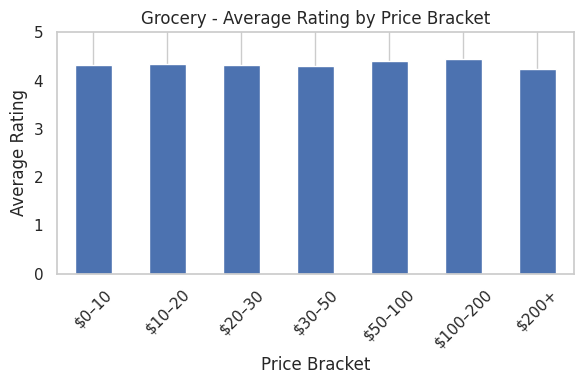


Home & Kitchen - Review Stats by Price Bracket

Price Bracket: $0–10
  Total Reviews: 802
  Average Rating: 4.47
  Median Rating: 5.00
  Std Dev of Rating: 1.08
  Reviews with Text: 802
  Reviews without Text: 0
  Verified Purchases: 652
  Unverified Purchases: 150

Price Bracket: $10–20
  Total Reviews: 2851
  Average Rating: 4.41
  Median Rating: 5.00
  Std Dev of Rating: 1.12
  Reviews with Text: 2851
  Reviews without Text: 0
  Verified Purchases: 2337
  Unverified Purchases: 514

Price Bracket: $20–30
  Total Reviews: 2328
  Average Rating: 4.41
  Median Rating: 5.00
  Std Dev of Rating: 1.09
  Reviews with Text: 2327
  Reviews without Text: 1
  Verified Purchases: 1887
  Unverified Purchases: 441

Price Bracket: $30–50
  Total Reviews: 1959
  Average Rating: 4.41
  Median Rating: 5.00
  Std Dev of Rating: 1.12
  Reviews with Text: 1959
  Reviews without Text: 0
  Verified Purchases: 1518
  Unverified Purchases: 441

Price Bracket: $50–100
  Total Reviews: 995
  Average Rating: 4

<ipython-input-28-187abaca56e6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['price_bracket'] = pd.cut(df_clean['price'], bins=price_bins, labels=price_labels, right=False)
<ipython-input-28-187abaca56e6>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_clean.groupby('price_bracket')


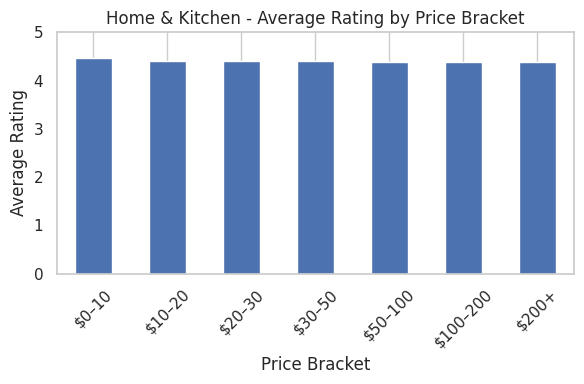


Beauty - Review Stats by Price Bracket

Price Bracket: $0–10
  Total Reviews: 8032
  Average Rating: 4.14
  Median Rating: 5.00
  Std Dev of Rating: 1.35
  Reviews with Text: 8030
  Reviews without Text: 2
  Verified Purchases: 7486
  Unverified Purchases: 546

Price Bracket: $10–20
  Total Reviews: 10048
  Average Rating: 4.20
  Median Rating: 5.00
  Std Dev of Rating: 1.30
  Reviews with Text: 10046
  Reviews without Text: 2
  Verified Purchases: 9343
  Unverified Purchases: 705

Price Bracket: $20–30
  Total Reviews: 4790
  Average Rating: 4.22
  Median Rating: 5.00
  Std Dev of Rating: 1.29
  Reviews with Text: 4788
  Reviews without Text: 2
  Verified Purchases: 4421
  Unverified Purchases: 369

Price Bracket: $30–50
  Total Reviews: 2231
  Average Rating: 4.32
  Median Rating: 5.00
  Std Dev of Rating: 1.22
  Reviews with Text: 2231
  Reviews without Text: 0
  Verified Purchases: 1923
  Unverified Purchases: 308

Price Bracket: $50–100
  Total Reviews: 1248
  Average Rating: 4.3

<ipython-input-28-187abaca56e6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['price_bracket'] = pd.cut(df_clean['price'], bins=price_bins, labels=price_labels, right=False)
<ipython-input-28-187abaca56e6>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_clean.groupby('price_bracket')


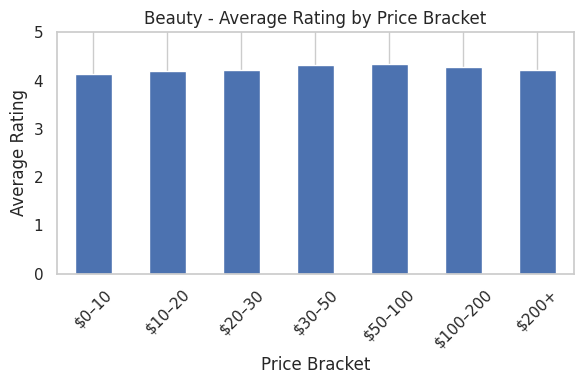


Electronics - Review Stats by Price Bracket

Price Bracket: $0–10
  Total Reviews: 2031
  Average Rating: 4.40
  Median Rating: 5.00
  Std Dev of Rating: 1.16
  Reviews with Text: 2030
  Reviews without Text: 1
  Verified Purchases: 1777
  Unverified Purchases: 254

Price Bracket: $10–20
  Total Reviews: 4016
  Average Rating: 4.35
  Median Rating: 5.00
  Std Dev of Rating: 1.19
  Reviews with Text: 4014
  Reviews without Text: 2
  Verified Purchases: 3450
  Unverified Purchases: 566

Price Bracket: $20–30
  Total Reviews: 1727
  Average Rating: 4.37
  Median Rating: 5.00
  Std Dev of Rating: 1.13
  Reviews with Text: 1726
  Reviews without Text: 1
  Verified Purchases: 1470
  Unverified Purchases: 257

Price Bracket: $30–50
  Total Reviews: 1326
  Average Rating: 4.31
  Median Rating: 5.00
  Std Dev of Rating: 1.22
  Reviews with Text: 1326
  Reviews without Text: 0
  Verified Purchases: 1068
  Unverified Purchases: 258

Price Bracket: $50–100
  Total Reviews: 1374
  Average Rating: 

<ipython-input-28-187abaca56e6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['price_bracket'] = pd.cut(df_clean['price'], bins=price_bins, labels=price_labels, right=False)
<ipython-input-28-187abaca56e6>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_clean.groupby('price_bracket')


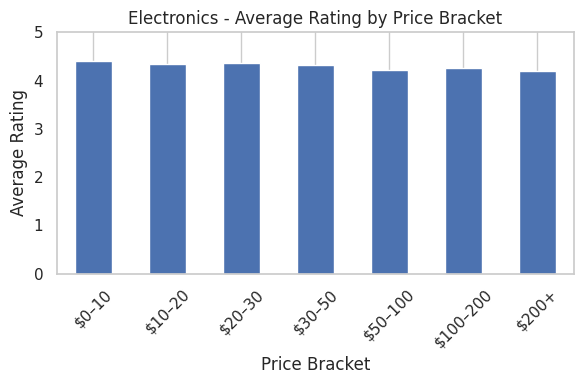


Pet Supplies - Review Stats by Price Bracket

Price Bracket: $0–10
  Total Reviews: 6674
  Average Rating: 4.25
  Median Rating: 5.00
  Std Dev of Rating: 1.24
  Reviews with Text: 6671
  Reviews without Text: 3
  Verified Purchases: 5788
  Unverified Purchases: 886

Price Bracket: $10–20
  Total Reviews: 13302
  Average Rating: 4.30
  Median Rating: 5.00
  Std Dev of Rating: 1.21
  Reviews with Text: 13300
  Reviews without Text: 2
  Verified Purchases: 11211
  Unverified Purchases: 2091

Price Bracket: $20–30
  Total Reviews: 7968
  Average Rating: 4.29
  Median Rating: 5.00
  Std Dev of Rating: 1.23
  Reviews with Text: 7966
  Reviews without Text: 2
  Verified Purchases: 6628
  Unverified Purchases: 1340

Price Bracket: $30–50
  Total Reviews: 5309
  Average Rating: 4.30
  Median Rating: 5.00
  Std Dev of Rating: 1.20
  Reviews with Text: 5309
  Reviews without Text: 0
  Verified Purchases: 4367
  Unverified Purchases: 942

Price Bracket: $50–100
  Total Reviews: 8469
  Average Ra

<ipython-input-28-187abaca56e6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['price_bracket'] = pd.cut(df_clean['price'], bins=price_bins, labels=price_labels, right=False)
<ipython-input-28-187abaca56e6>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_clean.groupby('price_bracket')


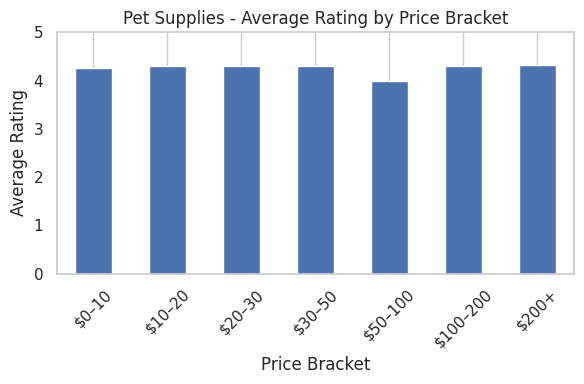

In [28]:
# Define price bins and labels
price_bins = [0, 10, 20, 30, 50, 100, 200, float('inf')]
price_labels = ['$0–10', '$10–20', '$20–30', '$30–50', '$50–100', '$100–200', '$200+']

for name, df in merged_dfs.items():
    print(f"\n{name} - Review Stats by Price Bracket")

    # Make sure price and rating are numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

    # Drop rows with missing price and average rating values
    df_clean = df.dropna(subset=['price', 'rating'])

    # Create price bracket column
    df_clean['price_bracket'] = pd.cut(df_clean['price'], bins=price_bins, labels=price_labels, right=False)

    # Group by price bracket
    grouped = df_clean.groupby('price_bracket')

    # Prepare and print stats for each price bracket
    for bracket, group in grouped:
        total = len(group)
        avg_rating = group['rating'].mean()
        median_rating = group['rating'].median()
        std_rating = group['rating'].std()
        with_text = group['text'].notna().sum()
        without_text = total - with_text
        verified = group['verified_purchase'].value_counts().get(True, 0)
        unverified = group['verified_purchase'].value_counts().get(False, 0)

        print(f"\nPrice Bracket: {bracket}")
        print(f"  Total Reviews: {total}")
        print(f"  Average Rating: {avg_rating:.2f}")
        print(f"  Median Rating: {median_rating:.2f}")
        print(f"  Std Dev of Rating: {std_rating:.2f}")
        print(f"  Reviews with Text: {with_text}")
        print(f"  Reviews without Text: {without_text}")
        print(f"  Verified Purchases: {verified}")
        print(f"  Unverified Purchases: {unverified}")

    # Plot average rating per bracket
    avg_rating_by_bracket = grouped['rating'].mean()

    plt.figure(figsize=(6, 4))
    avg_rating_by_bracket.plot(kind='bar')
    plt.title(f'{name} - Average Rating by Price Bracket')
    plt.xlabel('Price Bracket')
    plt.ylabel('Average Rating')
    plt.ylim(0, 5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

##Conduct correlation analysis to measure the strength and direction of the relationship between product price and customer ratings

In [42]:
from scipy.stats import spearmanr

for name, df in merged_dfs.items():
    print(f"\n{name} - Correlation Between Price and Rating")

    # Make sure price and rating are numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

    # Drop rows with no price or average rating
    df_clean = df.dropna(subset=['price', 'rating'])
    df_clean = df_clean[(df_clean['price'] > 0) & (df_clean['price'] < 500)]

    # Compute correlations
    corr, p = spearmanr(df_clean['price'], df_clean['rating'])

    print(f"Correlation: {corr:.3f} (p={p:.3f})")



Grocery - Correlation Between Price and Rating
Correlation: 0.004 (p=0.537)

Home & Kitchen - Correlation Between Price and Rating
Correlation: -0.017 (p=0.101)

Beauty - Correlation Between Price and Rating
Correlation: 0.044 (p=0.000)

Electronics - Correlation Between Price and Rating
Correlation: -0.055 (p=0.000)

Pet Supplies - Correlation Between Price and Rating
Correlation: -0.042 (p=0.000)


##Looking at sub categories within larger categories

First step: create arrays that store the values of all the disticint sub categories for each main category

In [31]:
# Define dictionary to store sub categories
sub_categories = {}

for name, df in merged_dfs.items():
  # Make set to store unique categories
  categories_set = set()
  for category_str in df['categories'].dropna():
      try:
          category_list = ast.literal_eval(category_str) # ast.literal_eval takes the string and makes it an array
          if isinstance(category_list, list):
              categories_set.update(category_list)
      except Exception as e:
          print(f"Skipping row due to error: {e}")
          continue
  # Remove any categories with numbers as they are generally not real categories (example '15% OFF')
  sub_categories[name] = sorted([cat for cat in categories_set if not any(char.isdigit() for char in cat)])
print(sub_categories)

{'Grocery': ['A Taste of Summer', 'APS Test', 'Active Dry Yeasts', 'Adobo Seasoning', 'Agave Nectar & Syrup', 'Ajowan', 'Alcoholic Beverages', 'Alfredo', 'Allspice', 'Almond', 'Almond Butter', 'Almond Milk', 'Almonds', 'American', 'Anchovies', 'Animal', 'Anise Seeds', 'Antipasto', 'Appetizers', 'Appetizers & Snacks', 'Apple Cider', 'Apples', 'Applesauce', 'Applesauce & Fruit Cups', 'Arborio', 'Arrowroot', 'Artichoke Hearts', 'Asafetida', 'Asiago', 'Asian', 'Asian Cuisine', 'Asparagus', 'Assortment Boxes', 'Assortments & Samplers', 'Assortments & Variety Gifts', 'August Special Events', 'Avocado', 'Avocados', 'Bacon', 'Bagel Chips', 'Bagels', 'Baguette', 'Baked Beans', "Baker's Ammonia", 'Bakery & Dessert Gifts', 'Baking Chips', 'Baking Chocolates, Carob & Cocoa', 'Baking Mixes', 'Baking Powder', 'Baking Soda', 'Baking Syrups, Sugars & Sweeteners', 'Baking essentials', 'Baklava', 'Balsamic', 'Bamboo', 'Bananas', 'Barbecue', 'Barbecue Seasoning', 'Barley Flour', 'Bars', 'Basil', 'Basmati

Step 2: Look at prive vs rating within sub categories

In [12]:
from scipy.stats import spearmanr

for name, df in meta_dfs.items():
    print(f"\n===== {name} - Price vs. Average Rating Correlation by Subcategory =====")

    # Make sure price and rating are numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')

    # Drop rows without needed values
    df_clean = df.dropna(subset=['price', 'average_rating', 'categories'])

    weighted_sum = 0
    total_weight = 0

    # Check eahc sub category and calculate correlation between price and rating
    for subcat in sub_categories[name]:
        matched_rows = []

        for _, row in df_clean.iterrows():
            try:
                cat_list = ast.literal_eval(row['categories'])
                if any(subcat in sub for sub in cat_list):
                    matched_rows.append(row)
            except:
                continue

        subcat_df = pd.DataFrame(matched_rows)

        # skip if not enough data or group is to large
        # If sub category is too large it likely encompasses multiple types of products
        n = len(subcat_df)
        if n < 30 or n > 1000:
            continue

        corr, p = spearmanr(subcat_df['price'], subcat_df['average_rating'])

        weighted_sum += corr * n
        total_weight += n

        # Formatted print to show all correlation coefficients and number of instances correclty
        print(f"{subcat[:30]:<30} | Spearman Corr: {corr:>6.2f} | n={n:>3}")

    # Calculated weighted correlation
    if total_weight > 0:
        weighted_corr = weighted_sum / total_weight
        print(f"\n Weighted Average Correlation for {name}: {weighted_corr:.4f}")



===== Grocery - Price vs. Average Rating Correlation by Subcategory =====
Active Dry Yeasts              | Spearman Corr:  -0.20 | n= 36
Almond                         | Spearman Corr:  -0.13 | n=260
Almond Butter                  | Spearman Corr:  -0.02 | n= 62
Almonds                        | Spearman Corr:  -0.14 | n=120
Antipasto                      | Spearman Corr:   0.32 | n= 38
Apple Cider                    | Spearman Corr:  -0.09 | n= 33
Apples                         | Spearman Corr:  -0.19 | n= 49
Applesauce                     | Spearman Corr:   0.14 | n= 32
Applesauce & Fruit Cups        | Spearman Corr:   0.14 | n= 32
Asian                          | Spearman Corr:   0.05 | n=415
Assortment Boxes               | Spearman Corr:   0.10 | n=225
Assortments & Samplers         | Spearman Corr:  -0.24 | n= 48
Assortments & Variety Gifts    | Spearman Corr:   0.06 | n= 49
Bacon                          | Spearman Corr:  -0.59 | n= 42
Bagels                         | Spearman C

KeyboardInterrupt: 

##Investigate further on more heavily correlated sub categories
Subcategories have been selected based on the ratio of their corelation coefficient over the amount of items in their category.

###For Grocery, we will be looking at:

1. Barbecue Seasoning:
  - corr= +0.30  n = 137
2. Powdered Drink Mixes
  - corr= +0.22 n = 263
3. Baking Mixes
  - corr= +0.20	n = 438

###For Home & Kitchen, we will be looking at:

1. Blinds & Shades:
  - corr= +0.30  n = 282
2. Artificial Flowers:
  - corr= +0.21 n = 494
3. Sheet & Pillowcase Sets:
  - corr= -0.27	n = 762

###For Electronics, we will be looking at:

1. Wearable Technology:
  - corr= -0.24  n = 929
2. Earpads:
  - corr= +0.34  n = 438
3. Camera Lenses:
  - corr= +0.36  n = 214

###For Pet Supplies, we will be looking at:
1. Boots:
  - corr= +0.45  n = 564
2. Sweaters:
  - corr= +0.27  n = 674
3. Fountains:
  - corr= -0.37  n = 270





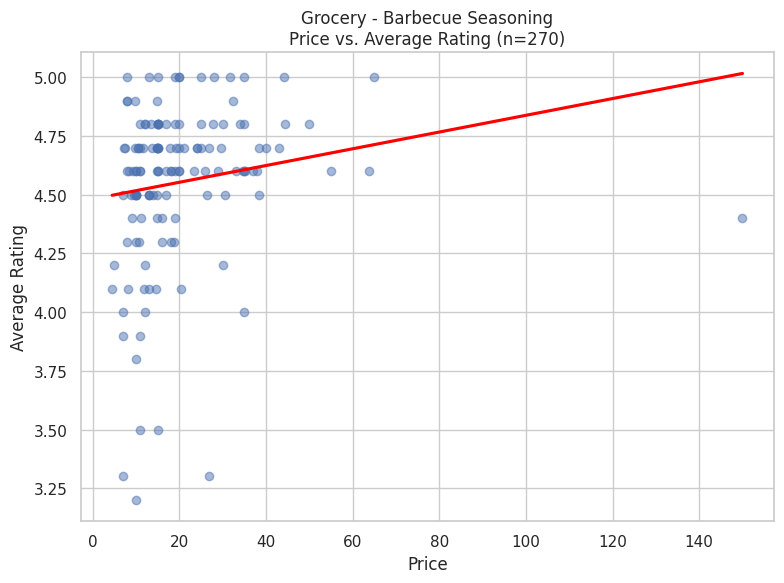

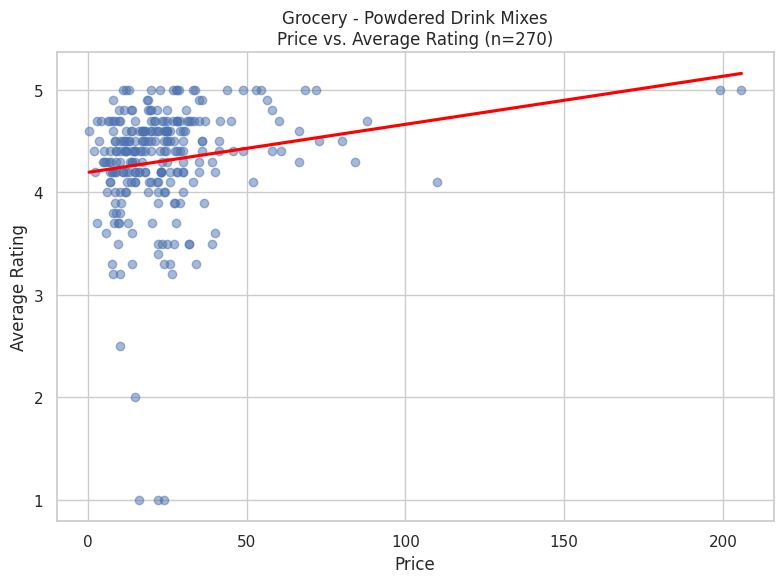

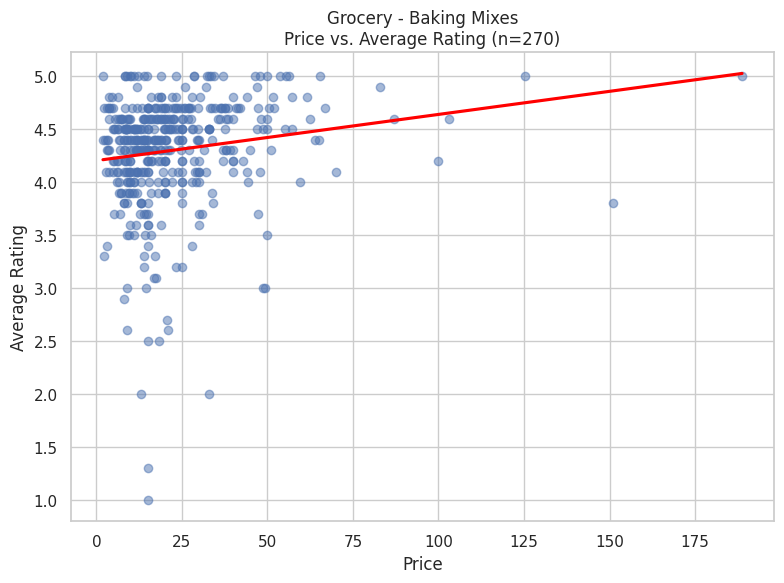

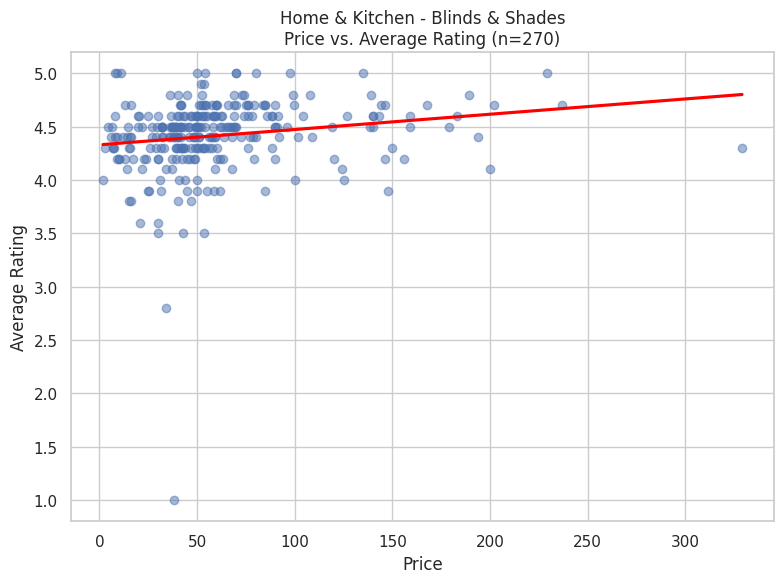

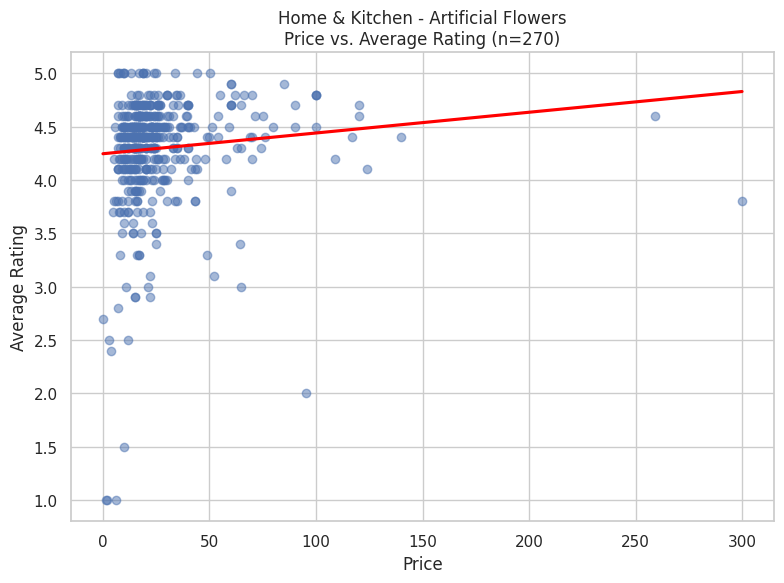

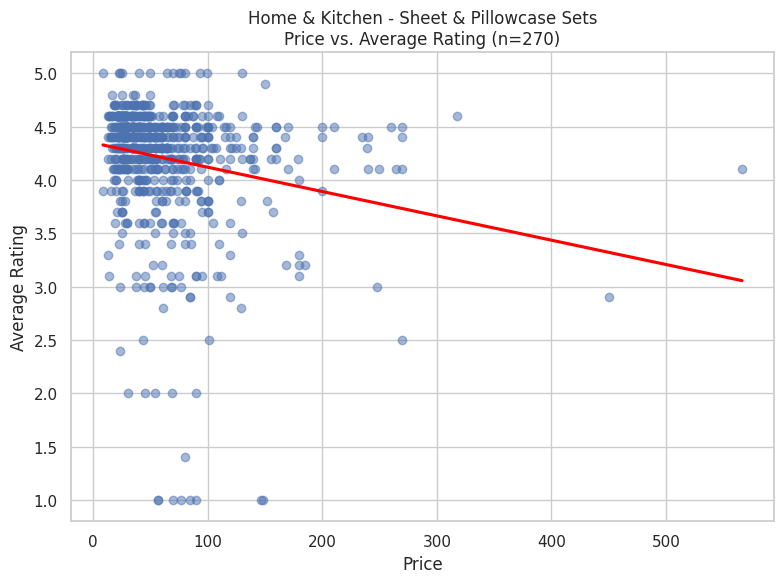

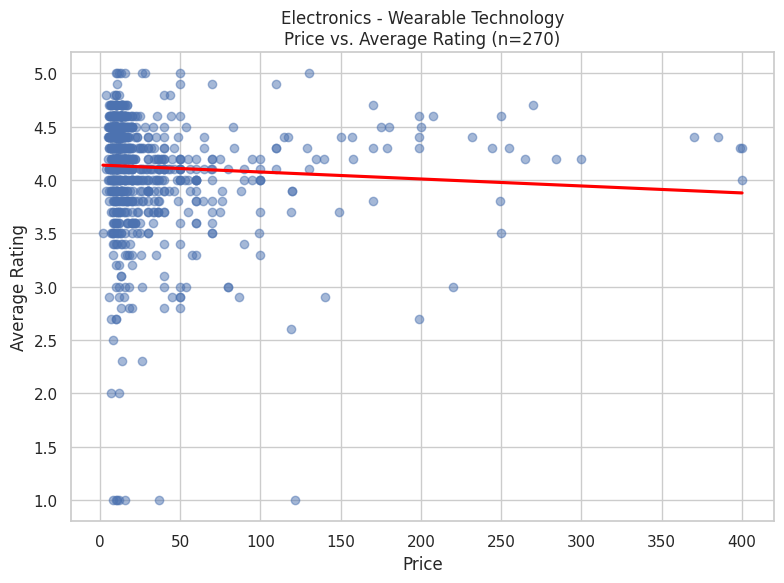

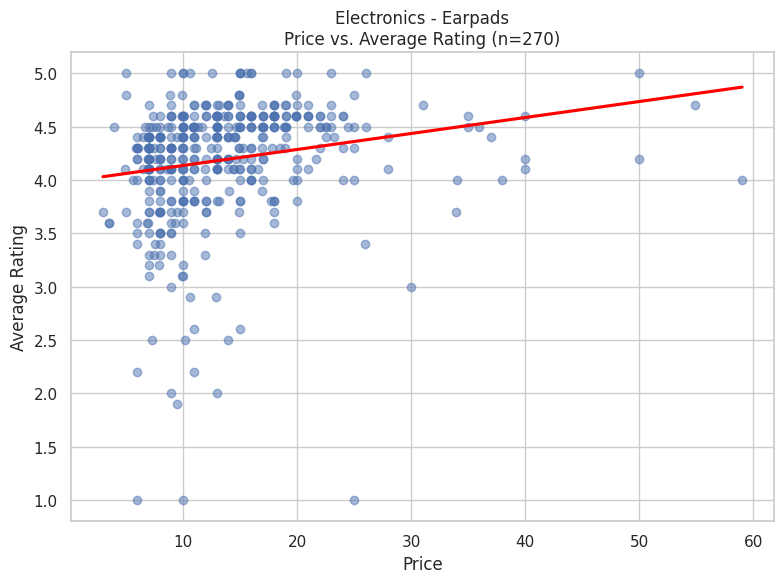

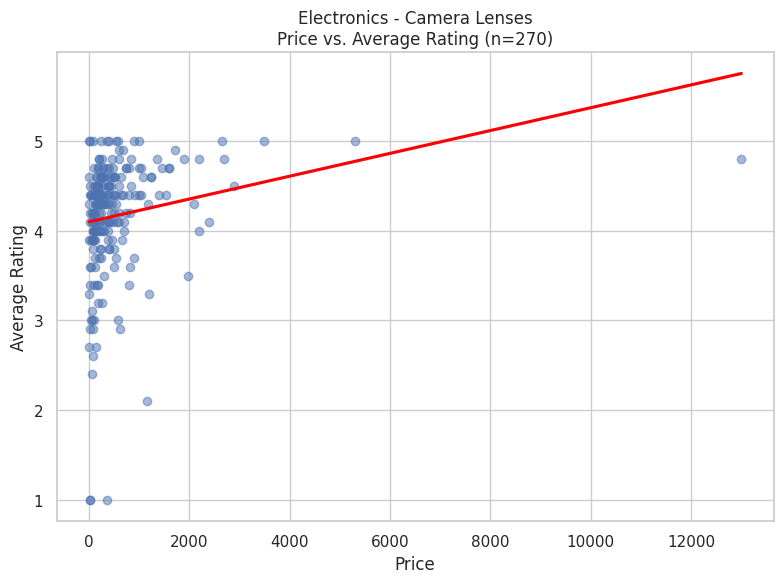

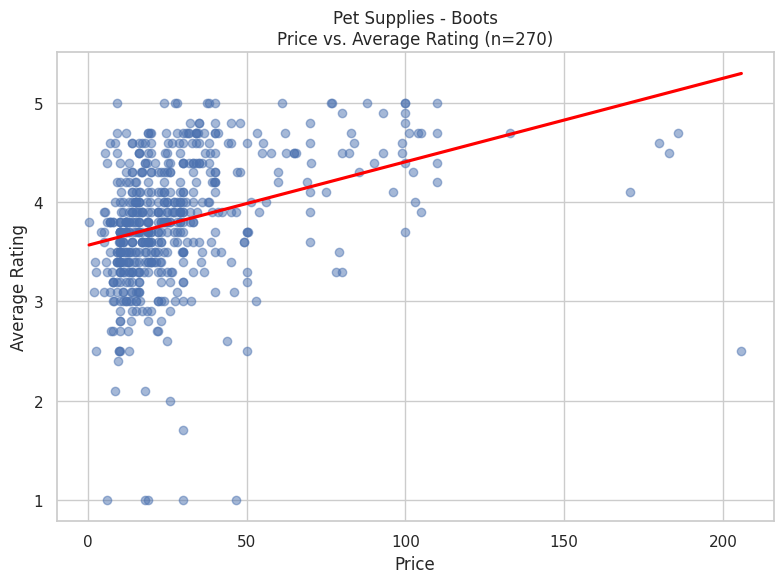

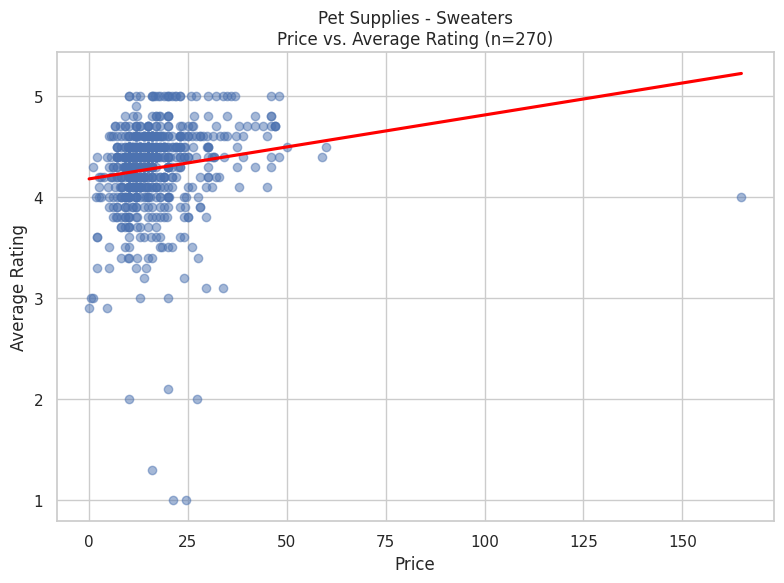

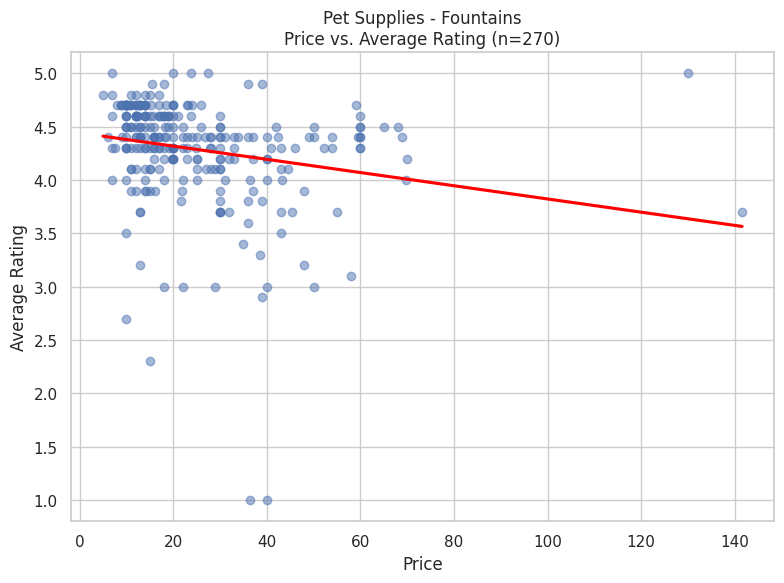

In [35]:
subcat_spesifics = {
    'Grocery': ['Barbecue Seasoning', 'Powdered Drink Mixes', 'Baking Mixes'],
    'Home & Kitchen': ['Blinds & Shades', 'Artificial Flowers', 'Sheet & Pillowcase Sets'],
    'Beauty': [],
    'Electronics': ['Wearable Technology', 'Earpads', 'Camera Lenses'],
    'Pet Supplies': ['Boots', 'Sweaters', 'Fountains']
}

# Loop through each main category and its specified subcategories
for main_cat, subcat_list in subcat_spesifics.items():
    df = meta_dfs[main_cat]

    # Make sure price and average rating are numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')

    # Drop rows that are missing any of these elements
    df_clean = df.dropna(subset=['price', 'average_rating', 'categories'])

    for subcat in subcat_list:
        # Match rows containing the subcategory in the 'categories' list
        matched_rows = []

        for _, row in df_clean.iterrows():
            try:
                cat_list = ast.literal_eval(row['categories'])
                if any(subcat in sub for sub in cat_list):
                    matched_rows.append(row)
            except:
                continue

        subcat_df = pd.DataFrame(matched_rows)

        # Create scatter plot with line of best fit
        plt.figure(figsize=(8, 6))
        sns.regplot(
            data=subcat_df,
            x='price',
            y='average_rating',
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'},
            ci=None
        )
        plt.title(f"{main_cat} - {subcat}\nPrice vs. Average Rating (n={n})")
        plt.xlabel("Price")
        plt.ylabel("Average Rating")
        plt.tight_layout()
        plt.show()


##Preform Linear Regression on Subcategories

In [40]:
from sklearn.linear_model import LinearRegression

for main_cat, subcat_list in subcat_spesifics.items():
    df = meta_dfs[main_cat]

    # Ensure numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')
    df_clean = df.dropna(subset=['price', 'average_rating', 'categories'])

    for subcat in subcat_list:
        matched_rows = []

        for _, row in df_clean.iterrows():
            try:
                cat_list = ast.literal_eval(row['categories'])
                if any(subcat in sub for sub in cat_list):
                    matched_rows.append(row)
            except:
                continue

        subcat_df = pd.DataFrame(matched_rows)

        n = len(subcat_df)
        if n < 30:
            print(f"Skipping {main_cat} > {subcat} (not enough data: n={n})")
            continue

        # Linear regression using scikit-learn
        X = subcat_df[['price']]
        y = subcat_df['average_rating']

        model = LinearRegression()
        model.fit(X, y)

        slope = model.coef_[0]
        intercept = model.intercept_
        r_squared = model.score(X, y)

        print(f"\n{main_cat} > {subcat} (n={n})")
        print(f"  Slope (price → rating): {slope:.4f}")
        print(f"  Intercept: {intercept:.4f}")
        print(f"  R² Score: {r_squared:.4f}")



Grocery > Barbecue Seasoning (n=137)
  Slope (price → rating): 0.0036
  Intercept: 4.4818
  R² Score: 0.0274

Grocery > Powdered Drink Mixes (n=263)
  Slope (price → rating): 0.0047
  Intercept: 4.1948
  R² Score: 0.0331

Grocery > Baking Mixes (n=438)
  Slope (price → rating): 0.0044
  Intercept: 4.2037
  R² Score: 0.0251

Home & Kitchen > Blinds & Shades (n=282)
  Slope (price → rating): 0.0014
  Intercept: 4.3308
  R² Score: 0.0313

Home & Kitchen > Artificial Flowers (n=494)
  Slope (price → rating): 0.0019
  Intercept: 4.2470
  R² Score: 0.0095

Home & Kitchen > Sheet & Pillowcase Sets (n=762)
  Slope (price → rating): -0.0023
  Intercept: 4.3493
  R² Score: 0.0405

Electronics > Wearable Technology (n=929)
  Slope (price → rating): -0.0007
  Intercept: 4.1412
  R² Score: 0.0037

Electronics > Earpads (n=438)
  Slope (price → rating): 0.0150
  Intercept: 3.9866
  R² Score: 0.0385

Electronics > Camera Lenses (n=214)
  Slope (price → rating): 0.0001
  Intercept: 4.0983
  R² Score:

##Preform Logistic regression on subcategories

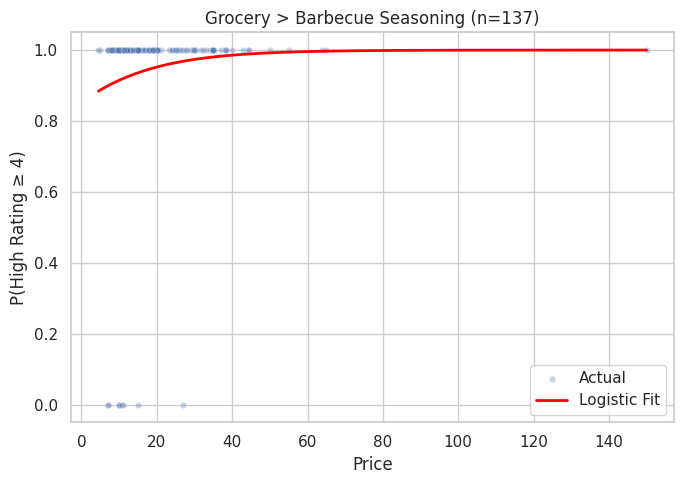


Grocery > Barbecue Seasoning (n=137)
Coefficient (price): 0.9942
Intercept: 3.0060
ROC AUC Score: 0.7345


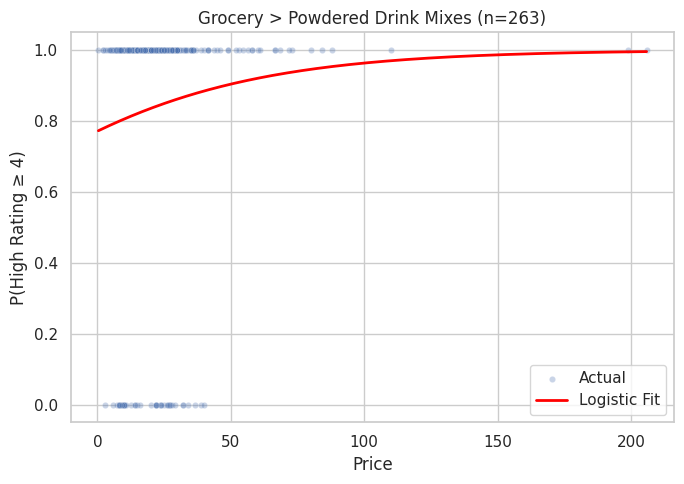


Grocery > Powdered Drink Mixes (n=263)
Coefficient (price): 0.4563
Intercept: 1.7130
ROC AUC Score: 0.5592


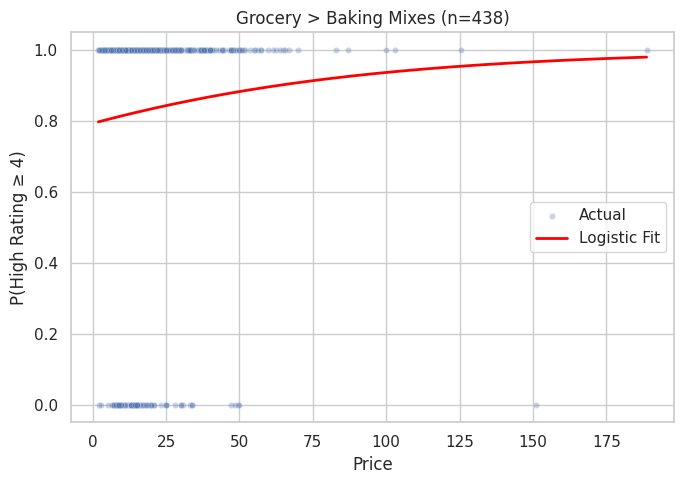


Grocery > Baking Mixes (n=438)
Coefficient (price): 0.2559
Intercept: 1.6453
ROC AUC Score: 0.5767


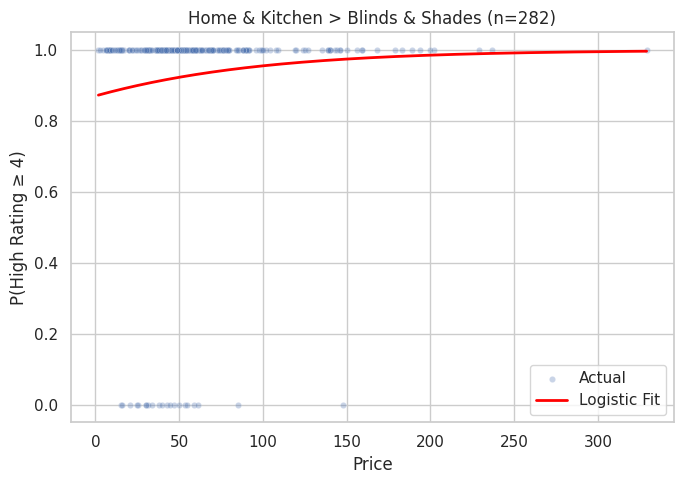


Home & Kitchen > Blinds & Shades (n=282)
Coefficient (price): 0.5118
Intercept: 2.6093
ROC AUC Score: 0.6331


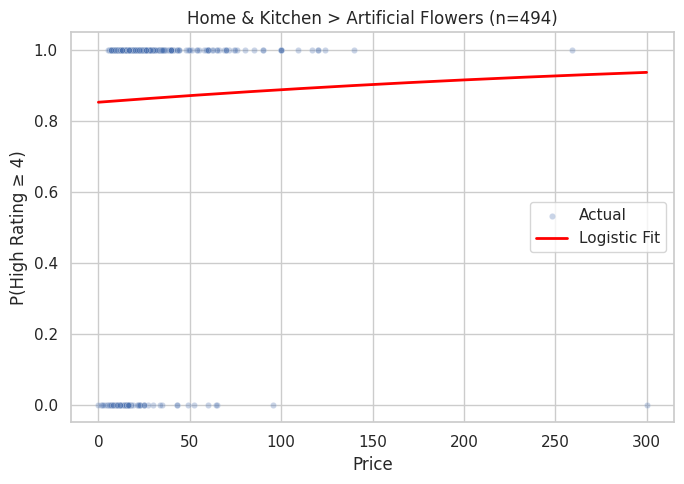


Home & Kitchen > Artificial Flowers (n=494)
Coefficient (price): 0.0803
Intercept: 1.8371
ROC AUC Score: 0.6239


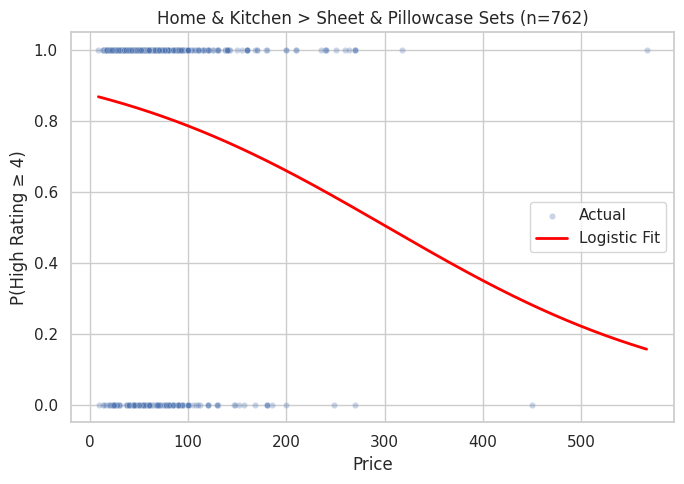


Home & Kitchen > Sheet & Pillowcase Sets (n=762)
Coefficient (price): -0.3220
Intercept: 1.5559
ROC AUC Score: 0.6584


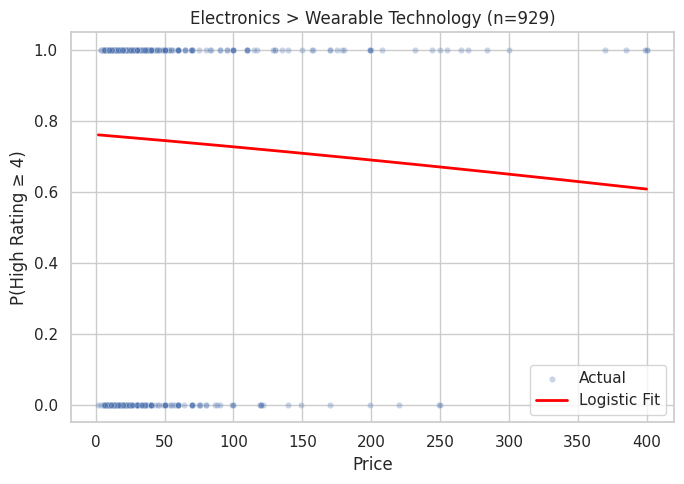


Electronics > Wearable Technology (n=929)
Coefficient (price): -0.0857
Intercept: 1.1070
ROC AUC Score: 0.6109


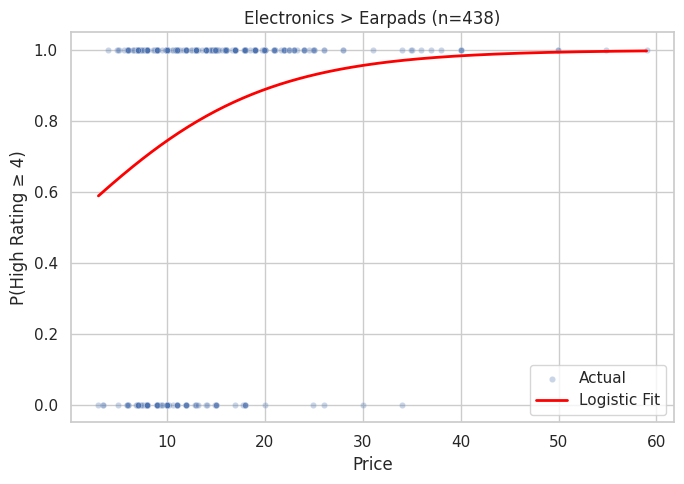


Electronics > Earpads (n=438)
Coefficient (price): 0.7485
Intercept: 1.4288
ROC AUC Score: 0.6574


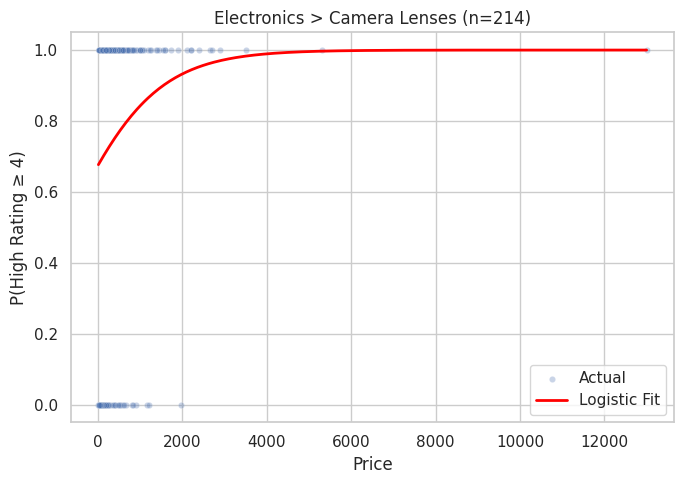


Electronics > Camera Lenses (n=214)
Coefficient (price): 1.0201
Intercept: 1.2699
ROC AUC Score: 0.6705


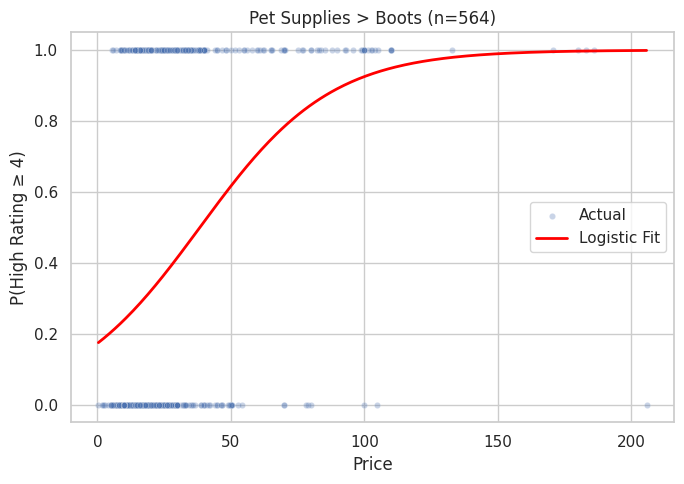


Pet Supplies > Boots (n=564)
Coefficient (price): 1.0857
Intercept: -0.3886
ROC AUC Score: 0.7462


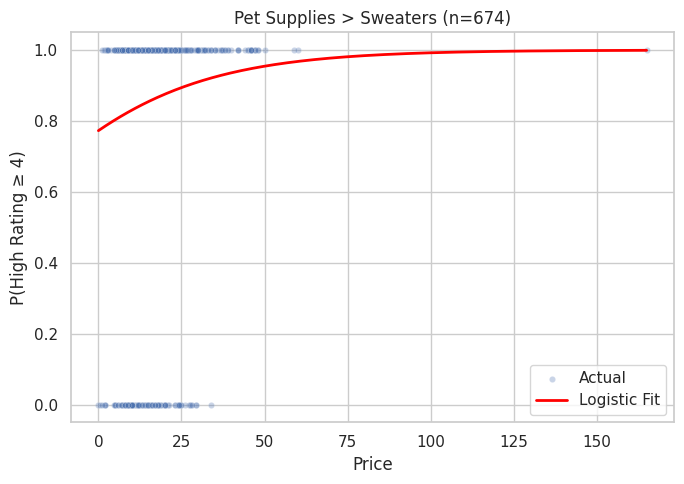


Pet Supplies > Sweaters (n=674)
Coefficient (price): 0.3827
Intercept: 1.8232
ROC AUC Score: 0.5693


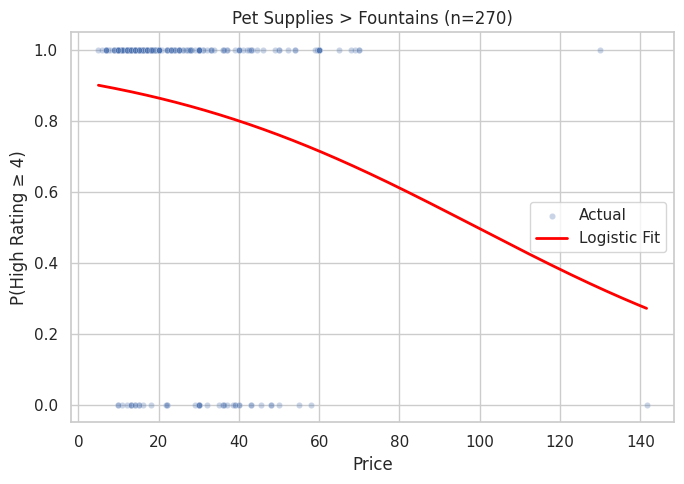


Pet Supplies > Fountains (n=270)
Coefficient (price): -0.4080
Intercept: 1.7453
ROC AUC Score: 0.6629


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.special import expit

for cat, subcats in subcat_spesifics.items():
    if not subcats:
        continue

    df = meta_dfs[cat].copy()
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')
    df = df.dropna(subset=['price', 'average_rating', 'categories'])

    for subcat in subcats:
        matched_rows = []

        for _, row in df.iterrows():
            try:
                cat_list = ast.literal_eval(row['categories'])
                if any(subcat in sub for sub in cat_list):
                    matched_rows.append(row)
            except:
                continue

        subcat_df = pd.DataFrame(matched_rows)

        if len(subcat_df) < 30:
            continue

        # Create binary target: 1 = high rating (>= 4), 0 = low (< 4)
        subcat_df['high_rating'] = (subcat_df['average_rating'] >= 4).astype(int)

        # Drop rows with invalid price
        subcat_df = subcat_df.dropna(subset=['price'])

        X = subcat_df[['price']].values
        y = subcat_df['high_rating'].values

        # Standardize prices for better fitting
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        model = LogisticRegression()
        model.fit(X_scaled, y)

        # Get predictions
        x_vals = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
        x_vals_scaled = scaler.transform(x_vals)
        probs = model.predict_proba(x_vals_scaled)[:, 1]

        # Plotting
        plt.figure(figsize=(7, 5))
        sns.scatterplot(x=subcat_df['price'], y=subcat_df['high_rating'], alpha=0.3, s=20, label="Actual")
        plt.plot(x_vals, probs, color='red', label="Logistic Fit", linewidth=2)

        plt.title(f"{cat} > {subcat} (n={len(subcat_df)})")
        plt.xlabel("Price")
        plt.ylabel("P(High Rating ≥ 4)")
        plt.ylim(-0.05, 1.05)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Print model stats
        coef = model.coef_[0][0]
        intercept = model.intercept_[0]
        print(f"\n{cat} > {subcat} (n={len(subcat_df)})")
        print(f"Coefficient (price): {coef:.4f}")
        print(f"Intercept: {intercept:.4f}")
        print(f"ROC AUC Score: {roc_auc_score(y, model.predict_proba(X_scaled)[:, 1]):.4f}")
